In [1]:
import pandas as pd
import time
import numpy as np
import pylab as plt
%matplotlib inline

# Data Import

In [2]:
folder = '/Users/ahuang/code/personal/CW5-169/data/'

#Trypsin datafiles
glycopeptide = 'df_reference_glycan_trypsin_FINAL.xlsx'
#chymotrypsin datafiles
glycopeptide_chymo = 'df_reference_glycan_chymo.xlsx'

dfg = pd.read_excel((folder + glycopeptide), sheetname='Sheet1')
dfg_chymo = pd.read_excel((folder + glycopeptide_chymo), sheetname='Sheet1')

#Glycoprotein fasta file
fasta = 'UniprotFasta.xlsx'
dffasta = pd.read_excel((folder + fasta) ,sheetname='Sheet1')

phosphosite = 'Phosphorylation_site_dataset.xlsx'
dfp = pd.read_excel((folder + phosphosite),sheetname='Sheet1')

In [6]:
df = pd.read_excel((folder + 'MasterOGlcNAc_uniprot_4-29-2016.xlsx'))
df['Binding_site_parse'] = df['Binding site'].str.split(';')

In [4]:
#entry is the primary key
print(df.shape)
print(df['Entry'].nunique())

(973, 26)
973


In [107]:
def try_int(x):
    try:
        return int(x)
    except ValueError:
        return x
    
def site_diff(a, b, site_diff_limit=99999, allow_description=False):
    # cross product of a and b modsites. calculates the pairwise distance and take the minimum
    start = time.time()
    
    #reset index adds the index as a column that the groupby function references to find the smallest site difference
    c = a.reset_index().merge(b, left_on='Protein Group Accessions', right_on='ACC_ID', how='outer')
    c['Site_diff'] = np.abs(c['Mod Site'] - c['SiteNumber'])
    
    if allow_description:
        output = c.sort_values(['index','Site_diff']).groupby('index').first()[['SiteNumber','Site_diff','Description']]
    else:
        output = c.sort_values(['index','Site_diff']).groupby('index').first()[['SiteNumber','Site_diff']]
    print('run time seconds: {}'.format(time.time() - start))

    #return output.reset_index()
    return output[output['Site_diff'] <= site_diff_limit].reset_index()

def structure_diff(a, b, site_diff_limit=99999):
    start = time.time()
    
    #reset index adds the index as a column that the groupby function references to find the smallest site difference
    c = a.reset_index().merge(b, left_on='Protein Group Accessions', right_on='Entry', how='outer')
    c['Mod_bound'] = (c['Start_site'] <= c['Mod Site']) & (c['End_site'] >= c['Mod Site'])

    output = c.groupby(['index','Protein Group Accessions','Mod Site']).sum()['Mod_bound']
    output = output.reset_index().drop(['Protein Group Accessions','Mod Site'],1)
    
    print('run time seconds: {}'.format(time.time() - start))
    return output

In [120]:
a = pd.DataFrame({'Protein Group Accessions':'abc','Mod Site':[1,2,4]})
b = pd.DataFrame({'ACC_ID':'abc','SiteNumber':[5,8,10,12]})
c = a.reset_index().merge(b, left_on='Protein Group Accessions', right_on='ACC_ID', how='outer')
c['Site_diff'] = np.abs(c['Mod Site'] - c['SiteNumber'])
output = c.sort_values(['index','Site_diff']).groupby('index').first()[['SiteNumber','Site_diff']]

# Prior work as of 09/24/2017

In [130]:
#building_columns -> column -> row within column -> entry -> evaluate elements within an entry
#converts string elements within an entry

site_df = pd.DataFrame(columns=['Entry','Column','Start_site','End_site','Description'])   
binding_columns = ['Binding site','Metal binding','DNA binding','Calcium binding',
                   'Active site','Nucleotide binding','Modified residue']

#loop through each column of binding columns
for column in binding_columns:
    print(column)
    #some rows in the column have np.nan. filter out nulls
    df_temp = df.loc[df[column].notnull(), ['Entry', column]].reset_index(drop=True)
    
    #each row can have multiple sites. delimited by ;. each delimited section is called an "entry"
    for idx, _ in enumerate(df_temp[column].str.split(';')):   
        
        #I'm assuming that the start site is at index 1, end site at index 2
        #test that: 1. the entry has at least 3 elements
        # that index 1 and index 2 are both integers
        for entry in _:
            entry_list = entry.split()
            if len(entry_list) >=3:
                entry_list = [try_int(x) for x in entry_list]
                if type(entry_list[1]) == int and type(entry_list[2]) == int:
                    
                    #insert the results into a output_df
                    if len(entry_list) == 3:
                        site_df.loc[len(site_df)]= [df_temp.loc[idx,'Entry'], column, entry_list[1], entry_list[2], np.nan]
                    else:
                        site_df.loc[len(site_df)]= [df_temp.loc[idx,'Entry'], column, entry_list[1], entry_list[2], entry_list[3]]
                    
                    
site_df['Mean_site'] = (site_df['Start_site'] + site_df['End_site'])/2

Binding site
Metal binding
DNA binding
Calcium binding
Active site
Nucleotide binding
Modified residue


In [ ]:
location_df = pd.DataFrame(columns=['Entry','Column','Subcellular_location'])   
binding_columns = ['Subcellular location [CC]']

for column in binding_columns:    
    df_temp = df.loc[df[column].notnull(), ['Entry', column]].reset_index(drop=True)
    
    for idx, _ in enumerate(df_temp[column].str.split(';')):   
        
        for entry in _:
            entry_list = entry.split()
            if len(entry_list) >=5:
                entry_list = [try_int(x) for x in entry_list]
                #assuming that the subcellular location follows "LOCATION:"
                if entry_list[1] == 'LOCATION:':
                    
                    #insert the results into a dataframe
                    location_df.loc[len(location_df)]= [df_temp.loc[idx,'Entry'], column, entry_list[4] ]

In [9]:
# location_df.to_excel('subcellularlocalization.xlsx')

In [ ]:
structure_df = pd.DataFrame(columns=['Entry','Column','Structure','Start_site','End_site'])   
binding_columns = ['Beta strand','Helix','Turn']

for column in binding_columns:
    
    df_temp = df.loc[df[column].notnull(), ['Entry', column]].reset_index(drop=True)
    
    for idx, _ in enumerate(df_temp[column].str.split(';')):   
        
        for entry in _:
            entry_list = entry.split()
            if len(entry_list) >=3:
                entry_list = [try_int(x) for x in entry_list]
                #assuming that the structure location follows "LOCATION:"
                if type(entry_list[1]) == int and type(entry_list[2]) == int:
                    
                    structure_df.loc[len(structure_df)]= [df_temp.loc[idx,'Entry'], column, entry_list[0], entry_list[1], entry_list[2] ]

In [20]:
a = dfg_chymo[['Protein Group Accessions','Mod Site']]
b = dfp[['ACC_ID','SiteNumber']]

output = site_diff(a,b)
dfg_chymo_to_dfp = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

run time seconds: 0.3225719928741455


In [21]:
a = dfg[['Protein Group Accessions','Mod Site']]
b = dfp[['ACC_ID','SiteNumber']]

output = site_diff(a,b)
dfg_to_dfp = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

run time seconds: 0.46935009956359863


In [13]:
a = dfg[['Protein Group Accessions','Mod Site']]

b = site_df.loc[site_df['Column'] == 'Binding site',['Entry','Mean_site']]
b.columns = ['ACC_ID','SiteNumber']
output = site_diff(a,b)
dfg_to_uniprot_BS = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

b = site_df.loc[site_df['Column'] == 'Metal binding',['Entry','Mean_site']]
b.columns = ['ACC_ID','SiteNumber']
output = site_diff(a,b)
dfg_to_uniprot_MB = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

b = site_df.loc[site_df['Column'] == 'DNA binding',['Entry','Mean_site']]
b.columns = ['ACC_ID','SiteNumber']
output = site_diff(a,b)
dfg_to_uniprot_DB = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

b = site_df.loc[site_df['Column'] == 'Calcium binding',['Entry','Mean_site']]
b.columns = ['ACC_ID','SiteNumber']
output = site_diff(a,b)
dfg_to_uniprot_CB = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

b = site_df.loc[site_df['Column'] == 'Active site',['Entry','Mean_site']]
b.columns = ['ACC_ID','SiteNumber']
output = site_diff(a,b)
dfg_to_uniprot_AS = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

b = site_df.loc[site_df['Column'] == 'Nucleotide binding',['Entry','Mean_site']]
b.columns = ['ACC_ID','SiteNumber']
output = site_diff(a,b)
dfg_to_uniprot_NB = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

# AHUANG 09/24/17 I removed the description field for consistency with the dataframes above
b = site_df.loc[site_df['Column'] == 'Modified residue',['Entry','Mean_site']]
b.columns = ['ACC_ID','SiteNumber']
output = site_diff(a,b)
dfg_to_uniprot_MR = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


run time seconds: 0.024289846420288086
run time seconds: 0.024731874465942383
run time seconds: 0.02105998992919922
run time seconds: 0.019133806228637695
run time seconds: 0.02048778533935547
run time seconds: 0.02067089080810547
run time seconds: 0.13564324378967285


In [14]:
a = dfg_chymo[['Protein Group Accessions','Mod Site']]

b = site_df.loc[site_df['Column'] == 'Binding site',['Entry','Mean_site']]
b.columns = ['ACC_ID','SiteNumber']
output = site_diff(a,b)
dfg_chymo_to_uniprot_BS = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

b = site_df.loc[site_df['Column'] == 'Metal binding',['Entry','Mean_site']]
b.columns = ['ACC_ID','SiteNumber']
output = site_diff(a,b)
dfg_chymo_to_uniprot_MB = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

b = site_df.loc[site_df['Column'] == 'DNA binding',['Entry','Mean_site']]
b.columns = ['ACC_ID','SiteNumber']
output = site_diff(a,b)
dfg_chymo_to_uniprot_DB = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

b = site_df.loc[site_df['Column'] == 'Calcium binding',['Entry','Mean_site']]
b.columns = ['ACC_ID','SiteNumber']
output = site_diff(a,b)
dfg_chymo_to_uniprot_CB = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

b = site_df.loc[site_df['Column'] == 'Active site',['Entry','Mean_site']]
b.columns = ['ACC_ID','SiteNumber']
output = site_diff(a,b)
dfg_chymo_to_uniprot_AS = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

b = site_df.loc[site_df['Column'] == 'Nucleotide binding',['Entry','Mean_site']]
b.columns = ['ACC_ID','SiteNumber']
output = site_diff(a,b)
dfg_chymo_to_uniprot_NB = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

b = site_df.loc[site_df['Column'] == 'Modified residue',['Entry','Mean_site','Description']]
b.columns = ['ACC_ID','SiteNumber','Description']
output = site_diff(a,b)
dfg_chymo_to_uniprot_MR = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

run time seconds: 0.017508745193481445
run time seconds: 0.020408153533935547
run time seconds: 0.018838882446289062
run time seconds: 0.01601409912109375
run time seconds: 0.01584601402282715
run time seconds: 0.015785932540893555
run time seconds: 0.10007691383361816


In [ ]:
#dfg_to_uniprot_sites = dfg_to_uniprot_BS.merge(dfg_to_uniprot_NB[['SiteNumber', 'Site_diff']], left_index=True, right_index=True)

In [ ]:
a = dfg[['Protein Group Accessions','Mod Site']]

b = structure_df.loc[structure_df['Column'] == 'Beta strand', ['Entry','Start_site','End_site']]
output = structure_diff(a,b)
dfg_to_structure_B = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

b = structure_df.loc[structure_df['Column'] == 'Helix', ['Entry','Start_site','End_site']]
output = structure_diff(a,b)
dfg_to_structure_H = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

b = structure_df.loc[structure_df['Column'] == 'Turn', ['Entry','Start_site','End_site']]
output = structure_diff(a,b)
dfg_to_structure_T = a.reset_index().merge(output, left_on='index', right_on='index', how='left')


In [28]:
a = dfg_chymo[['Protein Group Accessions','Mod Site']]

b = structure_df.ix[structure_df['Column'] == 'Beta strand', ['Entry','Start_site','End_site']]
output = structure_diff(a,b)
dfg_chymo_to_structure_B = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

b = structure_df.ix[structure_df['Column'] == 'Helix', ['Entry','Start_site','End_site']]
output = structure_diff(a,b)
dfg_chymo_to_structure_H = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

b = structure_df.ix[structure_df['Column'] == 'Turn', ['Entry','Start_site','End_site']]
output = structure_diff(a,b)
dfg_chymo_to_structure_T = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

run time seconds: 0.04165291786193848
run time seconds: 0.024344682693481445
run time seconds: 0.01676487922668457


# New work on 09/24/17

In [16]:
dfs = [dfg_chymo_to_uniprot_AS, dfg_chymo_to_uniprot_BS, dfg_chymo_to_uniprot_CB, dfg_chymo_to_uniprot_DB, dfg_chymo_to_uniprot_MB,dfg_chymo_to_uniprot_MR, dfg_chymo_to_uniprot_NB]
dfg_chymo = pd.concat(dfs).reset_index(drop=True)

# hacky way to add a column with the site type
site_type_list = ['AS','BS','CB','DB','MB','MR','NB']
site_type = [[site] * df.shape[0] for df, site in zip(dfs, site_type_list)]
flat_list = [item for sublist in site_type for item in sublist]
dfg_chymo['site_type'] = flat_list

In [17]:
dfs = [dfg_to_uniprot_AS ,dfg_to_uniprot_BS , dfg_to_uniprot_CB ,dfg_to_uniprot_DB ,dfg_to_uniprot_MB ,dfg_to_uniprot_MR ,dfg_to_uniprot_NB]
dfg_trypsin = pd.concat(dfs)

# hacky way to add a column with the site type
site_type_list = ['AS','BS','CB','DB','MB','MR','NB']
site_type = [[site] * df.shape[0] for df, site in zip(dfs, site_type_list)]
flat_list = [item for sublist in site_type for item in sublist]
dfg_trypsin['site_type'] = flat_list

In [18]:
df = pd.concat([dfg_trypsin, dfg_chymo]).dropna()

## example diff calculation (purely educational to re-familiarize AndrewH with calculation)

In [142]:
a = dfg[['Protein Group Accessions','Mod Site']]

b = site_df.loc[site_df['Column'] == 'Binding site',['Entry','Mean_site']]
b.columns = ['ACC_ID','SiteNumber']
output = site_diff(a,b)
dfg_to_uniprot_BS = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

run time seconds: 0.026700973510742188


In [168]:
print(dffasta[dffasta['Entry'] == 'A3KN83'].Sequence.values)

[ 'MVEPGQDLLLAALSESGISPNDLFDIDGGDAGLATPMPTPSVQQSVPLSALELGLETEAAVPVKQEPETVPTPALLNVRQQPPSTTTFVLNQINHLPPLGSTIVMTKTPPVTTNRQTITLTKFIQTTASTRPSVSAPTVRNAMTSAPSKDQVQLKDLLKNNSLNELMKLKPPANIAQPVATAATDVSNGTVKKESSNKEGARMWINDMKMRSFSPTMKVPVVKEDDEPEEEDEEEMGHAETYAEYMPIKLKIGLRHPDAVVETSSLSSVTPPDVWYKTSISEETIDNGWLSALQLEAITYAAQQHETFLPNGDRAGFLIGDGAGVGKGRTIAGIIYENYLLSRKRALWFSVSNDLKYDAERDLRDIGAKNILVHSLNKFKYGKISSKHNGSVKKGVIFATYSSLIGESQSGGKYKTRLKQLLHWCGDDFDGVIVFDECHKAKNLCPVGSSKPTKTGLAVLELQNKLPKARVVYASATGASEPRNMAYMNRLGIWGEGTPFREFSDFIQAVERRGVGAMEIVAMDMKLRGMYIARQLSFTGVTFKIEEVLLSQSYVKMYNKAVKLWVIARERFQQAADLIDAEQRMKKSMWGQFWSAHQRFFKYLCIASKVKRVVQLAREEIKNGKCVVIGLQSTGEARTLEALEEGGGELNDFVSTAKGVLQSLIEKHFPAPDRKKLYSLLGIDLTAPSNNSSPRDSPCKENKIKKRKGEEITREAKKARKVGGLTGSSSDDSGSESDASDNEESDYESSKNMSSGDDDDFNPFLDESNEDDENDPWLIRKDHKKNKEKKKKKSIDPDSIQSALLASGLGSKRPSFSSTPVISPAPNSTPANSNTNSNSSLITSQDAVERAQQMKKDLLDKLEKLAEDLPPNTLDELIDELGGPENVAEMTGRKGRVVSNDDGSISYESRSELDVPVEILNITEKQRFMDGDKNIAIISEAASSGISLQADRRAKNQRRRVHMTLELPWSADRAIQQFGRTHRSNQVTAPEYVFLIS

In [154]:
b.shape

(306, 2)

In [ ]:
for a protein group accession:    
    pick a random  associated with gene name

In [164]:
site_df.loc[site_df['Column'] == 'Binding site',['Entry','Mean_site']].head()

,Entry,Mean_site
0,O60502,67
1,O60502,98
2,O60502,174
3,O60502,219
4,O60502,285


## select a random mod site from FASTA

In [21]:
def find(s, ch):
    return [i for i, ltr in enumerate(s) if ltr == ch]

def random_modsite(sequence):
    candidate_modsites = find(sequence, 'S') + find(sequence, 'T')
    return np.random.choice(candidate_modsites)

def randomize_all_modsites(glycan_list, fasta_df):
    random_modsites = []
    for accession in glycan_list:
        try:
            # if FASTA has multiple eligible entries, retrieve all eligible Sequences
            # don't expect multiple eligible entries, but just to be safe
            candidate_sequences = fasta_df[fasta_df['Entry'] == accession].Sequence.tolist()
            # pick one entry and retrieve the sequence
            random_sequence  = np.random.choice(candidate_sequences)
            # Select one random 'S' or 'T' modsites
            random_modsites.append(random_modsite(random_sequence))
        except:
            random_modsites.append(np.NaN)

    random_modsites = pd.Series(random_modsites)
    random_modsites.name = 'Mod Site'
    return random_modsites

In [142]:
sequence = 'MVEPGQDLLLAALSESGISPNDLFDIDGGDAGLATPMPTPSVQQSVPLSALELGLETEAAVPVKQEPETVPTPALLNVRQQPPSTTTFVLNQINHLPPLGSTIVMTKTPPVTTNRQTITLTKFIQTTASTRPSVSAPTVRNAMTSAPSKDQVQLKDLLKNNSLNELMKLKPPANIAQPVATAATDVSNGTVKKESSNKEGARMWINDMKMRSFSPTMKVPVVKEDDEPEEEDEEEMGHAETYAEYMPIKLKIGLRHPDAVVETSSLSSVTPPDVWYKTSISEETIDNGWLSALQLEAITYAAQQHETFLPNGDRAGFLIGDGAGVGKGRTIAGIIYENYLLSRKRALWFSVSNDLKYDAERDLRDIGAKNILVHSLNKFKYGKISSKHNGSVKKGVIFATYSSLIGESQSGGKYKTRLKQLLHWCGDDFDGVIVFDECHKAKNLCPVGSSKPTKTGLAVLELQNKLPKARVVYASATGASEPRNMAYMNRLGIWGEGTPFREFSDFIQAVERRGVGAMEIVAMDMKLRGMYIARQLSFTGVTFKIEEVLLSQSYVKMYNKAVKLWVIARERFQQAADLIDAEQRMKKSMWGQFWSAHQRFFKYLCIASKVKRVVQLAREEIKNGKCVVIGLQSTGEARTLEALEEGGGELNDFVSTAKGVLQSLIEKHFPAPDRKKLYSLLGIDLTAPSNNSSPRDSPCKENKIKKRKGEEITREAKKARKVGGLTGSSSDDSGSESDASDNEESDYESSKNMSSGDDDDFNPFLDESNEDDENDPWLIRKDHKKNKEKKKKKSIDPDSIQSALLASGLGSKRPSFSSTPVISPAPNSTPANSNTNSNSSLITSQDAVERAQQMKKDLLDKLEKLAEDLPPNTLDELIDELGGPENVAEMTGRKGRVVSNDDGSISYESRSELDVPVEILNITEKQRFMDGDKNIAIISEAASSGISLQADRRAKNQRRRVHMTLELPWSADRAIQQFGRTHRSNQVTAPEYVFLISELAGEQRFASIVAKRLESLGALTHGDRRATESRDLSRFNFDNKYGRNALEIVMKSIVNLDSPMVSPPPDYPGEFFKDVRQGLIGVGLINVEDRSGILTLDKDYNNIGKFLNRILGMEVHQQNALFQYFADTLTAVVQNAKKNGRYDMGILDLGSGDEKVRKSDVKKFLTPGYSTSGHVELYTISVERGMSWEEATKIWAELTGPDDGFYLSLQIRNNKKTAILVKEVNPKKKLFLVYRPNTGKQLKLEIYADLKKKYKKVVSDDALMHWLDQYNSSADTCTHAYWRGNCKKASLGLVCEIGLRCRTYYVLCGSVLSVWTKVEGVLASVSGTNVKMQIVRLRTEDGQRIVGLIIPANCVSPLVNLLSTSDQSQQLAVQQKQLWQQHHPQSITNLSNA'
candidate_modsites = find(sequence, 'S') + find(sequence, 'T')

## re-run analysis with randomized modsites

In [131]:
#Trypsin
#a = pd.concat([dfg['Protein Group Accessions'], randomize_all_modsites(dfg, dffasta)],1)
a = s1_random_modsite.rename(columns={'UniProt Accession':'Protein Group Accessions'})

b = site_df.loc[site_df['Column'] == 'Binding site',['Entry','Mean_site']]
b.columns = ['ACC_ID','SiteNumber']
output = site_diff(a,b)
dfg_to_uniprot_BS = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

b = site_df.loc[site_df['Column'] == 'Metal binding',['Entry','Mean_site']]
b.columns = ['ACC_ID','SiteNumber']
output = site_diff(a,b)
dfg_to_uniprot_MB = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

b = site_df.loc[site_df['Column'] == 'DNA binding',['Entry','Mean_site']]
b.columns = ['ACC_ID','SiteNumber']
output = site_diff(a,b)
dfg_to_uniprot_DB = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

b = site_df.loc[site_df['Column'] == 'Calcium binding',['Entry','Mean_site']]
b.columns = ['ACC_ID','SiteNumber']
output = site_diff(a,b)
dfg_to_uniprot_CB = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

b = site_df.loc[site_df['Column'] == 'Active site',['Entry','Mean_site']]
b.columns = ['ACC_ID','SiteNumber']
output = site_diff(a,b)
dfg_to_uniprot_AS = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

b = site_df.loc[site_df['Column'] == 'Nucleotide binding',['Entry','Mean_site']]
b.columns = ['ACC_ID','SiteNumber']
output = site_diff(a,b)
dfg_to_uniprot_NB = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

# AHUANG 09/24/17 I removed the description field for consistency with the dataframes above
b = site_df.loc[site_df['Column'] == 'Modified residue',['Entry','Mean_site']]
b.columns = ['ACC_ID','SiteNumber']
output = site_diff(a,b)
dfg_to_uniprot_MR = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

run time seconds: 0.033802032470703125
run time seconds: 0.04489016532897949
run time seconds: 0.03543996810913086
run time seconds: 0.03505897521972656
run time seconds: 0.028116941452026367
run time seconds: 0.029861927032470703
run time seconds: 0.21544194221496582


In [132]:
# Chymo
#a = pd.concat([dfg_chymo['Protein Group Accessions'], randomize_all_modsites(dfg_chymo, dffasta)],1)
a = s1_random_modsite.rename(columns={'UniProt Accession':'Protein Group Accessions'})

b = site_df.loc[site_df['Column'] == 'Binding site',['Entry','Mean_site']]
b.columns = ['ACC_ID','SiteNumber']
output = site_diff(a,b)
dfg_chymo_to_uniprot_BS = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

b = site_df.loc[site_df['Column'] == 'Metal binding',['Entry','Mean_site']]
b.columns = ['ACC_ID','SiteNumber']
output = site_diff(a,b)
dfg_chymo_to_uniprot_MB = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

b = site_df.loc[site_df['Column'] == 'DNA binding',['Entry','Mean_site']]
b.columns = ['ACC_ID','SiteNumber']
output = site_diff(a,b)
dfg_chymo_to_uniprot_DB = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

b = site_df.loc[site_df['Column'] == 'Calcium binding',['Entry','Mean_site']]
b.columns = ['ACC_ID','SiteNumber']
output = site_diff(a,b)
dfg_chymo_to_uniprot_CB = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

b = site_df.loc[site_df['Column'] == 'Active site',['Entry','Mean_site']]
b.columns = ['ACC_ID','SiteNumber']
output = site_diff(a,b)
dfg_chymo_to_uniprot_AS = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

b = site_df.loc[site_df['Column'] == 'Nucleotide binding',['Entry','Mean_site']]
b.columns = ['ACC_ID','SiteNumber']
output = site_diff(a,b)
dfg_chymo_to_uniprot_NB = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

b = site_df.loc[site_df['Column'] == 'Modified residue',['Entry','Mean_site','Description']]
b.columns = ['ACC_ID','SiteNumber','Description']
output = site_diff(a,b)
dfg_chymo_to_uniprot_MR = a.reset_index().merge(output, left_on='index', right_on='index', how='left')

run time seconds: 0.04257678985595703
run time seconds: 0.04302382469177246
run time seconds: 0.030166149139404297
run time seconds: 0.02858591079711914
run time seconds: 0.03056192398071289
run time seconds: 0.029414892196655273
run time seconds: 0.23340702056884766


In [133]:
dfs = [dfg_chymo_to_uniprot_AS, dfg_chymo_to_uniprot_BS, dfg_chymo_to_uniprot_CB, dfg_chymo_to_uniprot_DB, dfg_chymo_to_uniprot_MB,dfg_chymo_to_uniprot_MR, dfg_chymo_to_uniprot_NB]
dfg_chymo = pd.concat(dfs)

# hacky way to add a column with the site type
site_type_list = ['AS','BS','CB','DB','MB','MR','NB']
site_type = [[site] * df.shape[0] for df, site in zip(dfs, site_type_list)]
flat_list = [item for sublist in site_type for item in sublist]
dfg_chymo['site_type'] = flat_list

dfs = [dfg_to_uniprot_AS ,dfg_to_uniprot_BS , dfg_to_uniprot_CB ,dfg_to_uniprot_DB ,dfg_to_uniprot_MB ,dfg_to_uniprot_MR ,dfg_to_uniprot_NB]
dfg_trypsin = pd.concat(dfs)

# hacky way to add a column with the site type
site_type_list = ['AS','BS','CB','DB','MB','MR','NB']
site_type = [[site] * df.shape[0] for df, site in zip(dfs, site_type_list)]
flat_list = [item for sublist in site_type for item in sublist]
dfg_trypsin['site_type'] = flat_list

dfn = pd.concat([dfg_trypsin, dfg_chymo]).dropna()
dfn['site_diff_bin'] = pd.cut(dfn.Site_diff.clip(0,110),[0,10,20,30,40,50,60,70,80,90,100,110])

In [158]:
dfn[dfn.Site_diff < 10].groupby('site_type').count()

,index,Protein Group Accessions,Mod Site,SiteNumber,Site_diff,site_diff_bin
site_type,,,,,,
AS,10,10,10,10,10,10
BS,132,132,132,132,132,116
CB,10,10,10,10,10,10
DB,66,66,66,66,66,66
MB,228,228,228,228,228,220
MR,7296,7296,7296,7296,7296,7012
NB,76,76,76,76,76,74


In [152]:
dfn[dfn.site_diff_bin == Interval(0, 10, closed='right')]

NameError: name 'Interval' is not defined

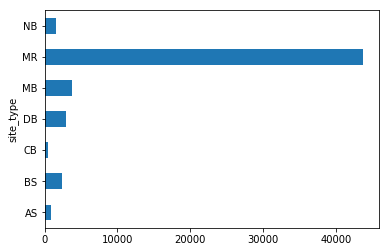

In [142]:
dfn.groupby('site_type').count().iloc[:,0].plot(kind='barh')

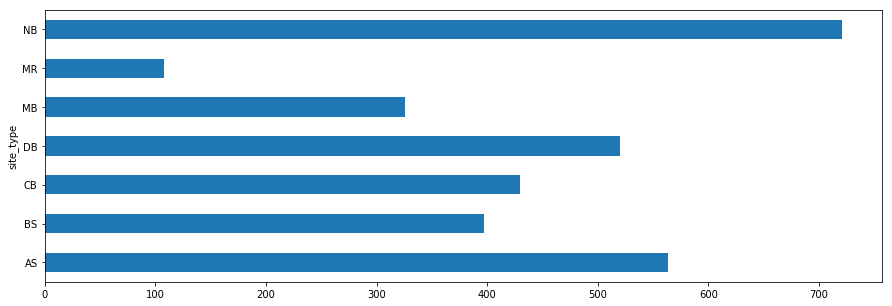

In [138]:
dfn.groupby('site_type')['Site_diff'].mean().plot(kind='barh', figsize=(15,5))

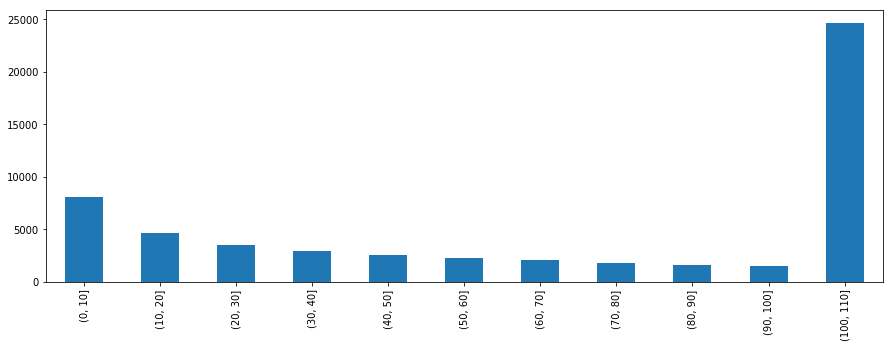

In [134]:
dfn.site_diff_bin.value_counts().sort_index().plot(kind='bar', figsize=(15,5))

# 20171001 analysis: randomized phosphosite distribution

In [9]:
s1 = pd.read_excel((folder + 'Supplementary Tables_1_revision.xlsx'), sheetname='TableS1_TotalGlycopeptides', header=1)

In [14]:
#Glycoprotein fasta file
fasta = 'UniprotFasta.xlsx'
dffasta = pd.read_excel((folder + fasta) ,sheetname='Sheet1')

In [ ]:
folder = '/Users/ahuang/code/personal/CW5-169/data/'
phosphosite = 'Phosphorylation_site_dataset.xlsx'
dfp = pd.read_excel((folder + phosphosite),sheetname='Sheet1')

In [ ]:
# Phosphosite
a = pd.concat([dfg_chymo['Protein Group Accessions'], randomize_all_modsites(dfg_chymo, dffasta)],1)

In [4]:
# Phosphosite
dfp.head()

,PROTEIN,ACC_ID,GENE,HU_CHR_LOC,MOD_RSD,SiteNumber,SITE_GRP_ID,ORGANISM,MW_kD,DOMAIN,SITE_+/-7_AA,LT_LIT,MS_LIT,MS_CST,CST_CAT#
0,14-3-3 beta,P31946,YWHAB,20q13.1,T2-p,2,15718712,human,28.08,NaN,______MtMDksELV,NaN,1.0,1.0,NaN
1,14-3-3 beta,P31946,YWHAB,20q13.1,S6-p,6,15718709,human,28.08,14-3-3,__MtMDksELVQkAk,NaN,3.0,NaN,NaN
2,14-3-3 beta,P31946,YWHAB,20q13.1,Y21-p,21,3426383,human,28.08,14-3-3,LAEQAERyDDMAAAM,NaN,NaN,3.0,NaN
3,14-3-3 beta,P31946,YWHAB,20q13.1,T32-p,32,23077803,human,28.08,14-3-3,AAAMKAVtEQGHELs,NaN,NaN,1.0,NaN
4,14-3-3 beta,P31946,YWHAB,20q13.1,S39-p,39,27442700,human,28.08,14-3-3,tEQGHELsNEERNLL,NaN,1.0,NaN,NaN


In [30]:
def find(s, ch):
    return [i for i, ltr in enumerate(s) if ltr == ch]

def random_modsite(sequence):
    candidate_modsites = find(sequence, 'S') + find(sequence, 'T')
    return np.random.choice(candidate_modsites)

def randomize_all_modsites(glycan_list, fasta_df):
    random_modsites = []
    for accession in glycan_list:
        try:
            # if FASTA has multiple eligible entries, retrieve all eligible Sequences
            # don't expect multiple eligible entries, but just to be safe
            candidate_sequences = fasta_df[fasta_df['Entry'] == accession].Sequence.tolist()
            # pick one entry and retrieve the sequence
            random_sequence  = np.random.choice(candidate_sequences)
            # Select one random 'S' or 'T' modsites
            random_modsites.append(random_modsite(random_sequence))
        except:
            random_modsites.append(np.NaN)

    random_modsites = pd.Series(random_modsites)
    random_modsites.name = 'Mod Site'
    return random_modsites

In [36]:
rdm_s1 = randomize_all_modsites(list(s1['UniProt Accession']), dffasta)
s1_random_modsite = pd.concat([s1['UniProt Accession'],rdm_s1],1)

In [61]:
s1_random_modsite['UniProt Accession'].unique()

array(['O95319', 'P51610', 'Q92879', ..., 'P30511', 'P05023', 'Q9NXE4'], dtype=object)

In [74]:
s1_random_modsite.head()

,UniProt Accession,Mod Site
0,O95319,306.0
1,O95319,333.0
2,O95319,387.0
3,O95319,295.0
4,O95319,211.0


In [90]:
output = []
for idx, row in  s1_random_modsite.iterrows():
    one_dfp = np.array(dfp.loc[dfp['ACC_ID'] == row[0],'SiteNumber'])
    if len(one_dfp) == 0:
        output.append(9999)
    else:
        min_distance = np.min(np.abs(one_dfp - row[1]))
        output.append(min_distance)

In [93]:
# Protein level comparison of S1 table randomized modsite to the closest Phosphosite modsite
s1_dfp = pd.DataFrame(output, columns=['rdm_site_diff'])

In [124]:
s1_dfp.rdm_site_diff.value_counts().sort_index().head(10)

0.0     915
1.0    4683
2.0     747
3.0     715
4.0     567
5.0     575
6.0     495
7.0     498
8.0     502
9.0     427
Name: rdm_site_diff, dtype: int64

In [103]:
s1_dfp.site_diff_bin.value_counts().sort_index()

(0, 10]       9600
(10, 20]      3059
(20, 30]      2098
(30, 40]      1512
(40, 50]      1083
(50, 60]       858
(60, 70]       717
(70, 80]       534
(80, 90]       476
(90, 100]      391
(100, 110]    1909
Name: site_diff_bin, dtype: int64

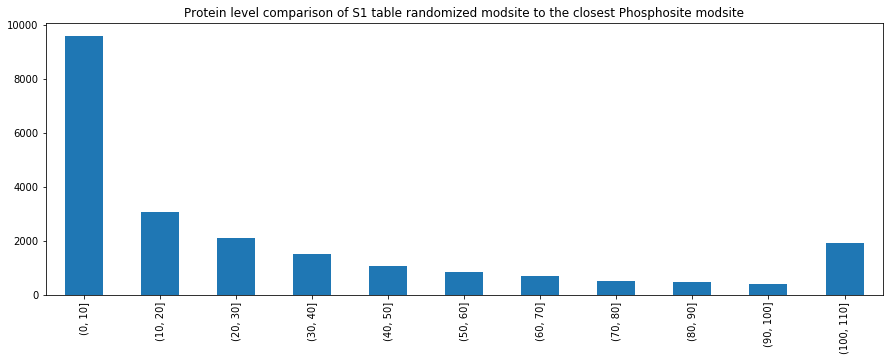

In [100]:
s1_dfp['site_diff_bin'] = pd.cut(s1_dfp.rdm_site_diff.clip(0,110),[0,10,20,30,40,50,60,70,80,90,100,110])
s1_dfp.site_diff_bin.value_counts().sort_index().plot(kind='bar', figsize=(15,5), title='Protein level comparison of S1 table randomized modsite to the closest Phosphosite modsite')
